In [1]:
import numpy as np


#Gaussian Kernel Function
def gaussian_kernel(u):
    """Gaussian kernel function"""
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u**2)

In [2]:

#Single Point Only
def nadaraya_watson_point(x0, x, y, h):
    """
    Compute Nadaraya-Watson estimate at point x0

    Parameters
    ----------
    x0 : float
        Prediction point
    x  : array-like
        Training inputs
    y  : array-like
        Training outputs
    h  : float
        Bandwidth

    Returns
    -------
    float
        Estimated value at x0
    """
    weights = gaussian_kernel((x0 - x) / h)
    return np.sum(weights * y) / np.sum(weights)

In [3]:
#Vectorized
def nadaraya_watson(x_train, y_train, x_pred, h):
    """
    Nadaraya-Watson regression for multiple prediction points
    """
    y_pred = np.zeros_like(x_pred, dtype=float)

    for i, x0 in enumerate(x_pred):
        weights = gaussian_kernel((x0 - x_train) / h)
        y_pred[i] = np.sum(weights * y_train) / np.sum(weights)

    return y_pred

In [4]:

def nw_bootstrap_ci(x, y, x_grid, h, B=500, alpha=0.05):
    n = len(x)
    boot_preds = np.zeros((B, len(x_grid)))

    for b in range(B):
        idx = np.random.choice(n, n, replace=True)
        x_b = x[idx]
        y_b = y[idx]
        boot_preds[b] = nadaraya_watson(x_b, y_b, x_grid, h)

    lower = np.percentile(boot_preds, 100 * alpha / 2, axis=0)
    upper = np.percentile(boot_preds, 100 * (1 - alpha / 2), axis=0)

    return lower, upper

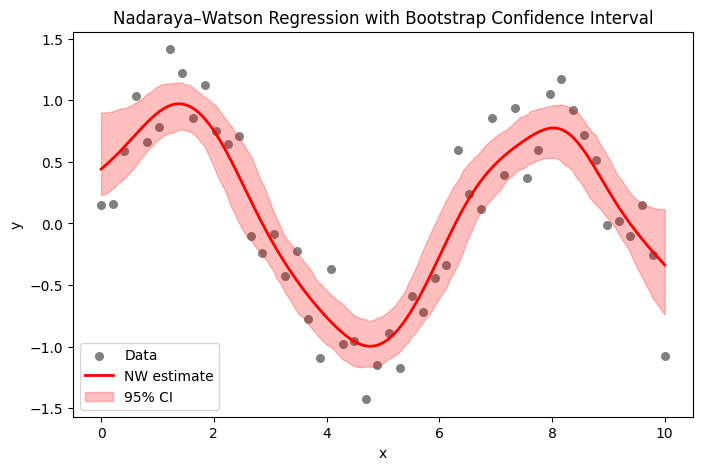

In [5]:
import matplotlib.pyplot as plt

np.random.seed(42)

# Generate data
x = np.linspace(0, 10, 50)
y = np.sin(x) + 0.3 * np.random.randn(50)

# Prediction grid
x_grid = np.linspace(0, 10, 300)

# Bandwidth
h = 0.5

# Fit NW
y_hat = nadaraya_watson(x, y, x_grid, h)

# Bootstrap CI
ci_lower, ci_upper = nw_bootstrap_ci(x, y, x_grid, h, B=500)

# Plot
plt.figure(figsize=(8,5))
plt.scatter(x, y, color="gray", s=30, label="Data")
plt.plot(x_grid, y_hat, color="red", lw=2, label="NW estimate")
plt.fill_between(x_grid, ci_lower, ci_upper,
                 color="red", alpha=0.25, label="95% CI")

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Nadaraya–Watson Regression with Bootstrap Confidence Interval")
plt.show()

Kernel is a KDE

In [6]:
def kde_1d(x, x_eval, h):
    n = len(x)
    kde_vals = np.zeros_like(x_eval, dtype=float)

    for i, x0 in enumerate(x_eval):
        u = (x0 - x) / h
        kde_vals[i] = np.sum(gaussian_kernel(u)) / (n * h)

    return kde_vals

In [7]:
def kde_weighted_nw(x, y, x_pred, h):
    # Estimate density at training points
    f_hat_x = kde_1d(x, x, h)

    y_pred = np.zeros_like(x_pred, dtype=float)

    for i, x0 in enumerate(x_pred):
        base_weights = gaussian_kernel((x0 - x) / h)
        weights = base_weights / f_hat_x
        y_pred[i] = np.sum(weights * y) / np.sum(weights)

    return y_pred

In [8]:

def kde_nw_bootstrap_ci(x, y, x_grid, h, B=500, alpha=0.05):
    n = len(x)
    boot_curves = np.zeros((B, len(x_grid)))

    for b in range(B):
        idx = np.random.choice(n, n, replace=True)
        x_b = x[idx]
        y_b = y[idx]

        boot_curves[b] = kde_weighted_nw(x_b, y_b, x_grid, h)

    lower = np.percentile(boot_curves, 100 * alpha / 2, axis=0)
    upper = np.percentile(boot_curves, 100 * (1 - alpha / 2), axis=0)

    return lower, upper

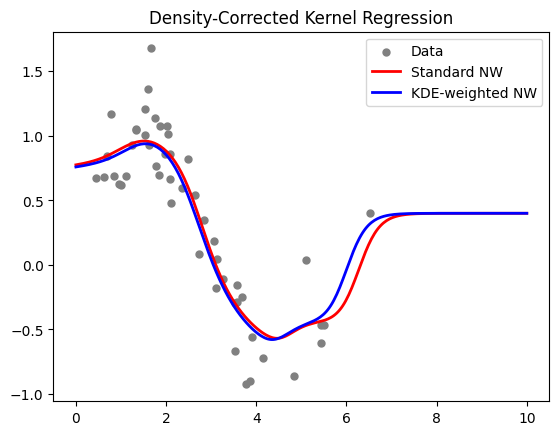

In [9]:
import matplotlib.pyplot as plt
np.random.seed(42)

x = np.sort(np.random.beta(2, 5, 50) * 10)
y = np.sin(x) + 0.25 * np.random.randn(50)

x_grid = np.linspace(0, 10, 300)
h = 0.5

y_nw = nadaraya_watson(x, y, x_grid, h)
y_kde_nw = kde_weighted_nw(x, y, x_grid, h)

plt.scatter(x, y, color="gray", s=25, label="Data")
plt.plot(x_grid, y_nw, color="red", lw=2, label="Standard NW")
plt.plot(x_grid, y_kde_nw, color="blue", lw=2, label="KDE-weighted NW")
plt.legend()
plt.title("Density-Corrected Kernel Regression")
plt.show()

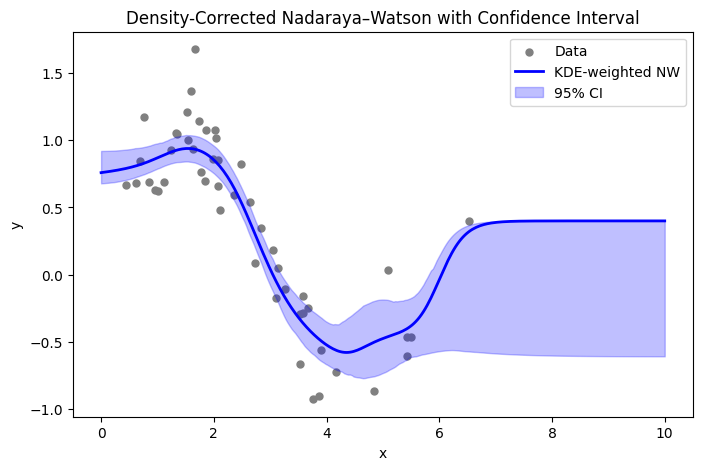

In [10]:
import matplotlib.pyplot as plt

np.random.seed(42)

# Uneven design (important use case)
x = np.sort(np.random.beta(2, 5, 50) * 10)
y = np.sin(x) + 0.25 * np.random.randn(50)

x_grid = np.linspace(0, 10, 300)
h = 0.5

# Fit
y_hat = kde_weighted_nw(x, y, x_grid, h)

# CI
ci_low, ci_up = kde_nw_bootstrap_ci(x, y, x_grid, h, B=500)

# Plot
plt.figure(figsize=(8,5))
plt.scatter(x, y, s=25, color="gray", label="Data")
plt.plot(x_grid, y_hat, color="blue", lw=2, label="KDE-weighted NW")
plt.fill_between(x_grid, ci_low, ci_up,
                 color="blue", alpha=0.25, label="95% CI")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Density-Corrected Nadaraya–Watson with Confidence Interval")
plt.show()

**Adaptive KDE**

In [40]:
def gaussian_kernel(u):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u**2)


def kde_1d(x, x_eval, h):
    n = len(x)
    out = np.zeros_like(x_eval, dtype=float)

    for i, x0 in enumerate(x_eval):
        out[i] = np.sum(gaussian_kernel((x0 - x) / h)) / (n * h)

    return out


def kde_weighted_nw_adaptive(x, y, x_pred, h):
    f_hat_x = kde_1d(x, x, h)

    y_pred = np.zeros_like(x_pred, dtype=float)
    for i, x0 in enumerate(x_pred):
        base_w = gaussian_kernel((x0 - x) / h)
        w = base_w / f_hat_x
        y_pred[i] = np.sum(w * y) / np.sum(w)

    return y_pred

def kde_nw_bootstrap_ci(x, y, x_grid, h, B=300, alpha=0.05):
    n = len(x)
    boot_curves = np.zeros((B, len(x_grid)))

    for b in range(B):
        idx = np.random.choice(n, n, replace=True)
        x_b = x[idx]
        y_b = y[idx]
        boot_curves[b] = kde_weighted_nw(x_b, y_b, x_grid, h)

    lower = np.percentile(boot_curves, 100 * alpha / 2, axis=0)
    upper = np.percentile(boot_curves, 100 * (1 - alpha / 2), axis=0)

    return lower, upper

In [50]:
# sample data
x = np.linspace(0, 10, 100)
y = np.sin(x) + 0.25 * np.random.randn(100)

x_grid = np.linspace(0, 10, 300)
h = 0.8

In [48]:
# Prediction grid (daily)
x_grid = np.linspace(x.min(), x.max(), 400)


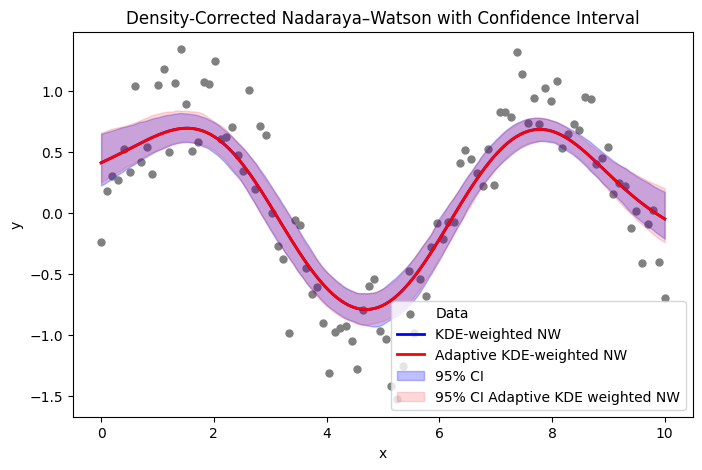

In [52]:
# Fit
y_hat = kde_weighted_nw(x, y, x_grid, h)
y_adaptive = kde_weighted_nw_adaptive(x, y, x_grid, h)

# CI
ci_low, ci_up = kde_nw_bootstrap_ci(x, y, x_grid, h, B=500)
ci_low_adap, ci_up_adap = kde_nw_bootstrap_ci(x, y, x_grid, h, B=300, alpha=0.05)
# Plot
plt.figure(figsize=(8,5))
plt.scatter(x, y, s=25, color="gray", label="Data")
plt.plot(x_grid, y_hat, color="blue", lw=2, label="KDE-weighted NW")
plt.plot(x_grid, y_adaptive, color="red", lw=2, label="Adaptive KDE-weighted NW")
plt.fill_between(x_grid, ci_low, ci_up,
                 color="blue", alpha=0.25, label="95% CI")
plt.fill_between(x_grid, ci_low_adap, ci_up_adap,
                 color="red", alpha=0.15, label="95% CI Adaptive KDE weighted NW")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Density-Corrected Nadaraya–Watson with Confidence Interval")
plt.show()